<a href="https://colab.research.google.com/github/AraiKensuke/FitSpectrum/blob/master/FitPowerSpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install nitime              #  
!pip install arviz==0.5.1        # pymc3 on Colab is v3.7.  We need old version of arviz

import sys
import importlib

if importlib.util.find_spec("FitSpectrum") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/FitSpectrum.git

sys.path.insert(1, "/content/FitSpectrum")
import FitSpectrum.buildsignal as bs

import pymc3 as pm
import numpy as _N
import matplotlib.pyplot as plt; plt.ion()

####  fit to PYMC3 model using posterior sampling.
####  model assumes up to 3 bumps in power spectrum
def do_fit_psd(f_at_obs, log_psd):
  # # define the model/function to be fitted.

  with pm.Model() as model3:
    #  SPECIFY prior distributions for parameters
    #amp = pm.Uniform('amp', 0.05, 0.4, testval= 0.15)
    amp1 = pm.HalfNormal('amp1', sigma=1)
    amp2 = pm.HalfNormal('amp2', sigma=1)
    amp3 = pm.HalfNormal('amp3', sigma=1)
    #size = pm.Uniform('size', 0.1, 2.5, testval= 1.0)
    width1 = pm.HalfNormal('width1', sigma=2)
    width2 = pm.HalfNormal('width2', sigma=2)
    width3= pm.HalfNormal('width3', sigma=2)
    mu1 = pm.Normal('mu1', mu=1, sigma=5)   #  initialize w/ diff values
    mu2 = pm.Normal('mu2', mu=15, sigma=5)
    mu3 = pm.Normal('mu3', mu=30, sigma=5)
    a = pm.HalfNormal('a', 20)
    b = pm.Normal('b', 0.13, 40)
    c = pm.Normal('c', mu=0., sigma=4)

    error = pm.HalfNormal("error", sigma=0.3)
    ####  Gaussian noise assumed on top of a/(f+b) shape
    gauss=pm.Deterministic('gauss',amp1*_N.exp(-0.5*(f_at_obs-mu1)**2/(width1**2))+amp2*_N.exp(-0.5*(f_at_obs-mu2)**2/(width2**2))+amp3*_N.exp(-0.5*(f_at_obs-mu3)**2/(width3**2))+a/(f_at_obs+b) + c)

    y =pm.Normal('y', mu=gauss, sigma=error, observed=log_psd)

    #map_estimate=pm.find_MAP()    #  can also do point MAP estimate 
    step=pm.NUTS()
    trace=pm.sample(2000)

  return trace, model3


In [51]:
import FitSpectrum.buildsignal as bs
import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate


Routines to create an oscillating signal with some spectral width, ie a signal whose instantaneous period fluctuates.

First, let's see what short time MT powerspec of a very tight oscillation looks like:

---



MT powerspec for a tight oscillation

(1.0, 55.0)

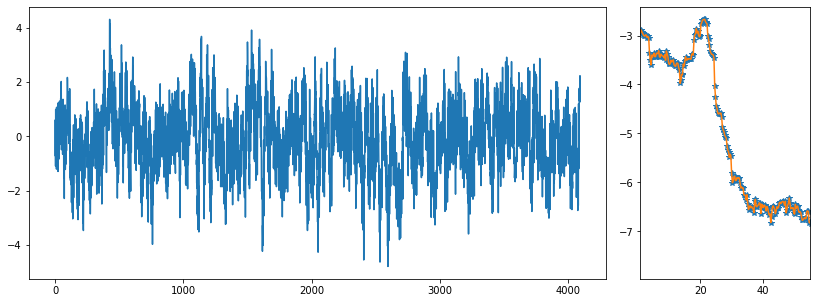

In [ ]:
_N.random.seed(1000)   #  set the random seed.

###  Specify the signal 
f1=21.   # hz
coh1=0.982   # how coherent or sinusoidal is f1 osc?  0~1    1 near sinusoidal, > 0.95 neural-like

obs_nz    = 0.8   #  make this bigger to add more observation noise
comps         = [[[f1, coh1]], [0.96]]      #  describe AR(p) in terms of AR(2) and AR(1) components.
N             = 4096
dt            = 0.001
#  
signal         = bs.build_signal(N, dt, [comps], [1])  
signal         += obs_nz*_N.random.randn(N)    #  add observation noise (white noise)


fig = plt.figure(figsize=(14, 5))
plt.subplot2grid((1, 4), (0, 0), colspan=3)
plt.plot(signal)
plt.subplot2grid((1, 4), (0, 3), colspan=1)
# multi-taper: for now, let's work on the average of tapers
# focus on 1 to 30 Hz
bw = 9
f, psd_mt, nu = tsa.multi_taper_psd(signal,Fs=1/dt, NW=bw , low_bias=False, adaptive=False, jackknife=False)
plt.plot(f,_N.log(psd_mt),'*')
plt.plot(f, _N.log(psd_mt))
plt.xlim(1,55)

In [ ]:

# # extract and plot results
# y_min = _N.percentile(trace.gauss,2.5,axis=0)
# y_max = _N.percentile(trace.gauss,97.5,axis=0)
# y_fit = _N.percentile(trace.gauss,50,axis=0)
# plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
# plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
# plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
# plt.fill_between(x, y_min, y_max, color='0.d5', alpha=0.5)
# plt.legend()


Now perform fit on PSD

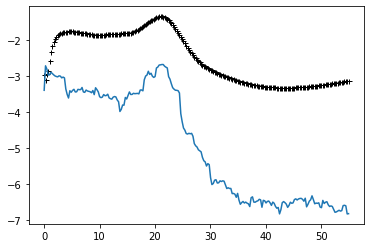

In [ ]:
theseInds = _N.where(f < 55)[0]
f_psd     = f[theseInds]

#trace = do_fit_psd(f_psd, _N.log(psd_mt[theseInds]))
y_fit = _N.percentile(trace.gauss,50,axis=0)
plt.plot(f_psd, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(f_psd, _N.log(psd_mt[theseInds]))

**Look at Gibbs samples and marginal posterior distributions of parameters**


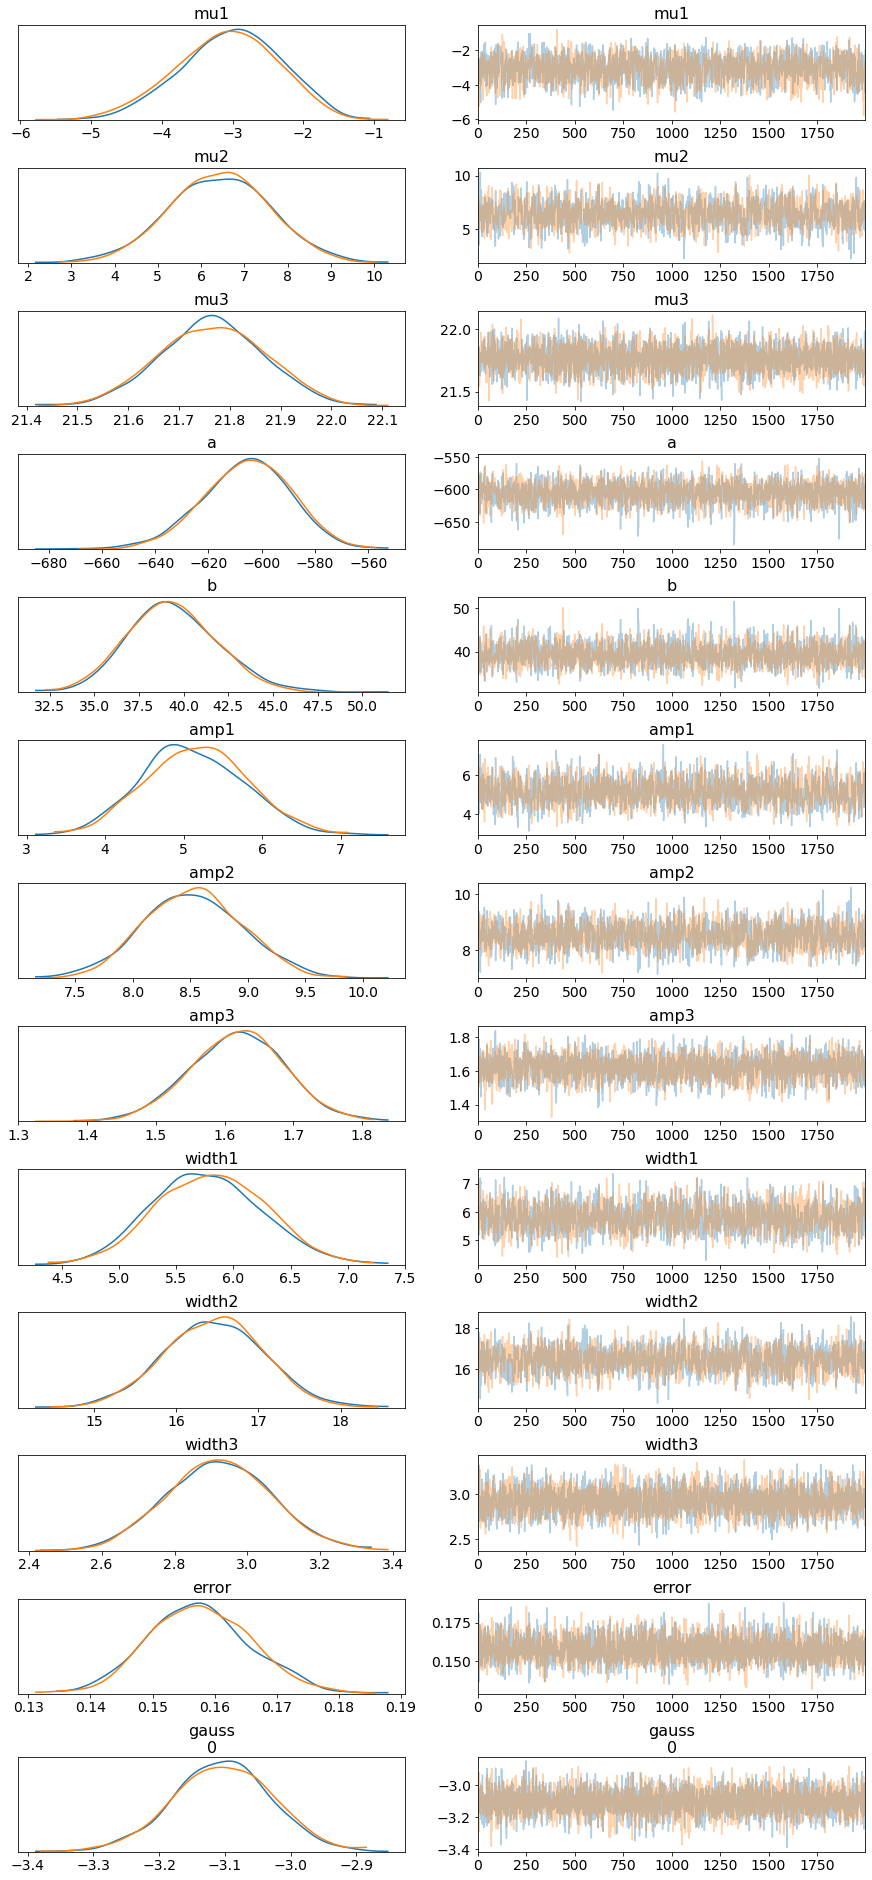

In [ ]:
trace = do_fit_psd(f_at_obs, log_psd)

import arviz as az
with model3:
    az.plot_trace(trace);

**Now let's load some actual EEG data recorded while a subject closed for about 15 seconds, and then openned their eyes for about 15 seconds.**
There is a clear qualitative difference in the way the EEG looks.

In [52]:
eeg = _N.loadtxt("FitSpectrum/jan142021_01_00_00_smpl_v1.dat")

#  eeg has 5 channels of eeg data, 30 seconds in duration sampled at 300Hz.  shape is 9000 x 5

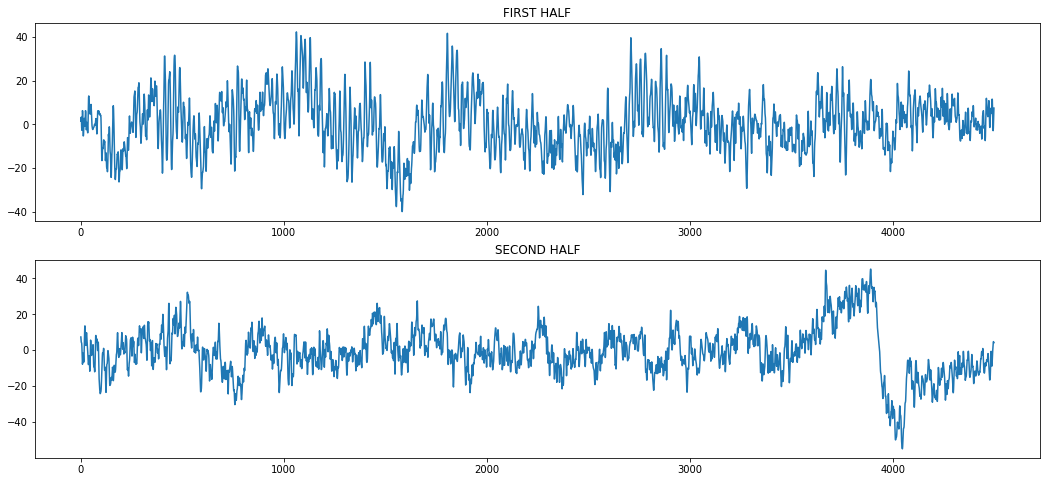

In [53]:
eeg_channel = 0
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(2, 1, 1)
plt.title("FIRST HALF")
plt.plot(eeg[0:4500, eeg_channel])
fig.add_subplot(2, 1, 2)
plt.title("SECOND HALF")
plt.plot(eeg[4500:, eeg_channel])

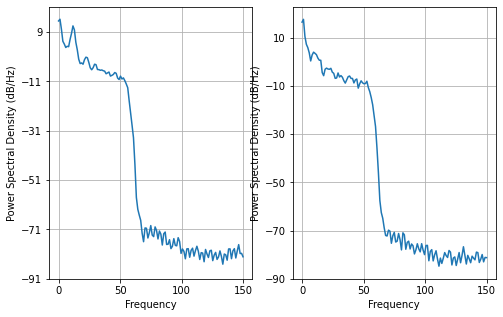

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(1, 2, 1)
eeg_psd1, eeg_f_psd1 = plt.psd(eeg[0:4500, eeg_channel], Fs=300)
fig.add_subplot(1, 2, 2)
eeg_psd2, eeg_f_psd2 = plt.psd(eeg[4500:, eeg_channel], Fs=300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, c, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [00:53<00:00, 46.67it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


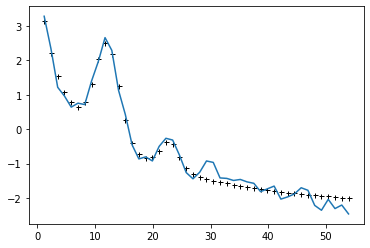

In [54]:
theseInds = _N.where((eeg_f_psd1 < 55) & (eeg_f_psd1 > 0))[0]

trace1, model = do_fit_psd(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))
y_fit = _N.percentile(trace1.gauss,50,axis=0)
plt.plot(eeg_f_psd1[theseInds], y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))

In [ ]:
y_fit

array([1.18802702, 1.14581507, 0.91612416, 0.67563153, 0.55257424,
       0.52985688, 0.62900753, 0.83664822, 1.05394801, 1.15969876,
       0.96103255, 0.62954036, 0.32509028, 0.1516313 , 0.07640138,
       0.04300438, 0.02590826, 0.01815175, 0.01563475, 0.01230306,
       0.01137857, 0.01091157, 0.00961979, 0.00393266, 0.10805611,
       0.07584165, 0.06830596, 0.05555929, 0.04502809, 0.03822343,
       0.03301591, 0.02932968, 0.0261066 , 0.02348477, 0.02156549,
       0.02032952, 0.01890708, 0.01794482, 0.01748943, 0.01658886,
       0.01579348, 0.01521735, 0.01466043, 0.01403144, 0.01345622,
       0.01302765])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, c, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [00:39<00:00, 64.04it/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


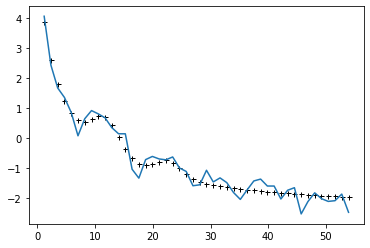

In [55]:
theseInds = _N.where((eeg_f_psd2 < 55) & (eeg_f_psd2 > 0))[0]

trace2, model2 = do_fit_psd(eeg_f_psd2[theseInds], _N.log(eeg_psd2[theseInds]))
y_fit = _N.percentile(trace2.gauss,50,axis=0)
plt.plot(eeg_f_psd2[theseInds], y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(eeg_f_psd2[theseInds], _N.log(eeg_psd2[theseInds]))

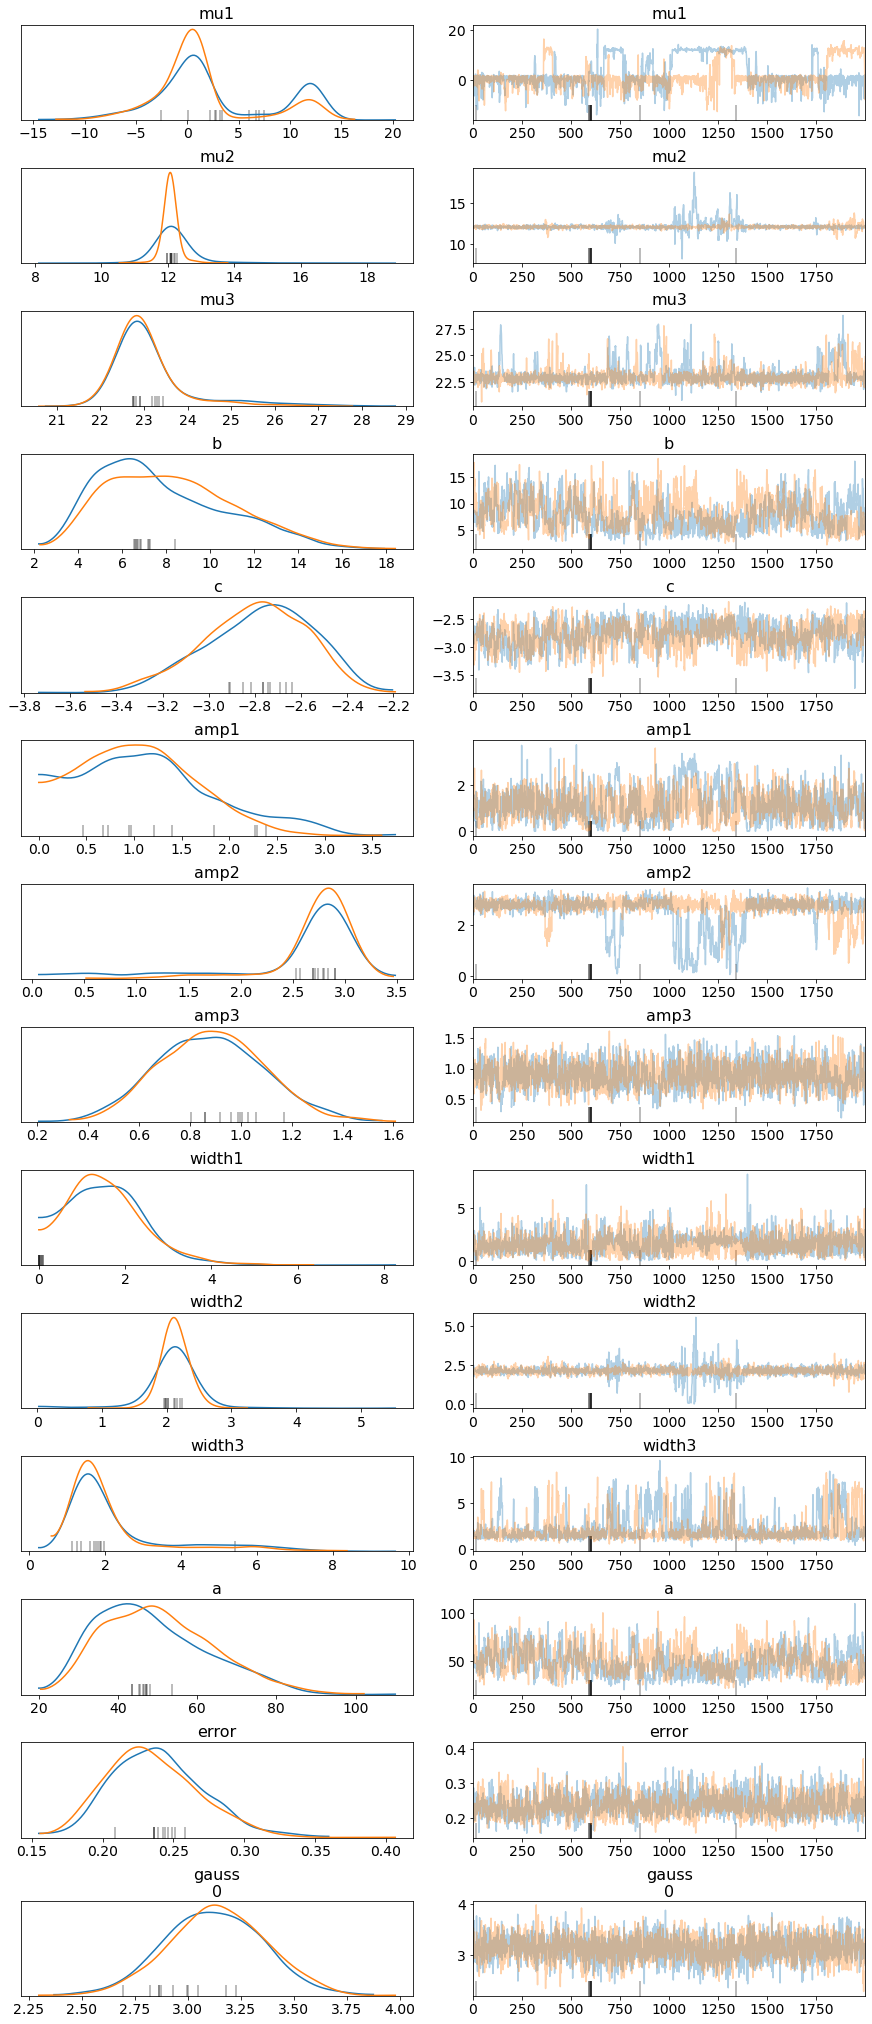

In [56]:

import arviz as az
with pm.Model() as model:
    az.plot_trace(trace1);

In [ ]:
f_at_obs

NameError: ignored

In [ ]:
eeg_f_psd2

array([  0.      ,   1.171875,   2.34375 ,   3.515625,   4.6875  ,
         5.859375,   7.03125 ,   8.203125,   9.375   ,  10.546875,
        11.71875 ,  12.890625,  14.0625  ,  15.234375,  16.40625 ,
        17.578125,  18.75    ,  19.921875,  21.09375 ,  22.265625,
        23.4375  ,  24.609375,  25.78125 ,  26.953125,  28.125   ,
        29.296875,  30.46875 ,  31.640625,  32.8125  ,  33.984375,
        35.15625 ,  36.328125,  37.5     ,  38.671875,  39.84375 ,
        41.015625,  42.1875  ,  43.359375,  44.53125 ,  45.703125,
        46.875   ,  48.046875,  49.21875 ,  50.390625,  51.5625  ,
        52.734375,  53.90625 ,  55.078125,  56.25    ,  57.421875,
        58.59375 ,  59.765625,  60.9375  ,  62.109375,  63.28125 ,
        64.453125,  65.625   ,  66.796875,  67.96875 ,  69.140625,
        70.3125  ,  71.484375,  72.65625 ,  73.828125,  75.      ,
        76.171875,  77.34375 ,  78.515625,  79.6875  ,  80.859375,
        82.03125 ,  83.203125,  84.375   ,  85.546875,  86.718